These are the necessary imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBRegressor
import pickle

Getting the dataframe from a csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/colab_datasets/twitterscraping/alldatacleaned.csv', index_col=None)
df = df.drop_duplicates()

Making a copy of the dataframe to work on it so initial state of the dataset can be restored in case something bad happens.
**Note : *** I will be referencing to the number of likes, number of comments, and number of retweets as **reaction indices**

In [ ]:
dfcopy = df.copy()

Dropping the 'Content' column because we cannot extract useful data from it anymore

In [ ]:
dfcopy = dfcopy.drop(columns=['Content'])

Some of the data has zero as the number of likes, retweets, and comments respectively, which means that the extraction of the data was wrong (as observed in the dataset, some users have tousands of followers and thousands of tweets but have not a single intercation on a post that was putted more than a day ago). However, some users who have less than five followers and less than five posts have no interaction on their last post, which makes sense. So, I created a function that drops rows where there is no interaction (zero likes, comments, and retweets) if their correspondant user have more than five followers or more than five posts

In [ ]:
def dropzeros(df):
  l = []
  for i in range(df.shape[0]):
    if (df['NumberOfLikes'].iloc[i] == 0 and df['NumberOfRetweets'].iloc[i] == 0 and df['NumberOfComments'].iloc[i] == 0):
      l.append(i)
  df.drop(df.index[l], inplace=True)

def dropzeros(df):
  l = []
  for i in range(df.shape[0]):
    if (df['NumberOfLikes'].iloc[i] == 0 and df['NumberOfRetweets'].iloc[i] == 0 and df['NumberOfComments'].iloc[i] == 0 and (df['NumberofTweets'].iloc[i] < 6 or df['NumberofFollowers'].iloc[i] < 6)):
      l.append(i)
  df.drop(df.index[l], inplace=True)

In [ ]:
dropzeros(dfcopy)

The correlation map shows that the number of reaction indices' columns are weakly correlated to other columns

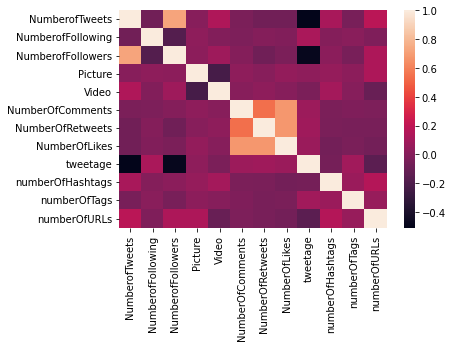

In [ ]:
corr = dfcopy.corr()
sns.heatmap(corr)

This shows that only a small percentage of the rows actually have a video content in them

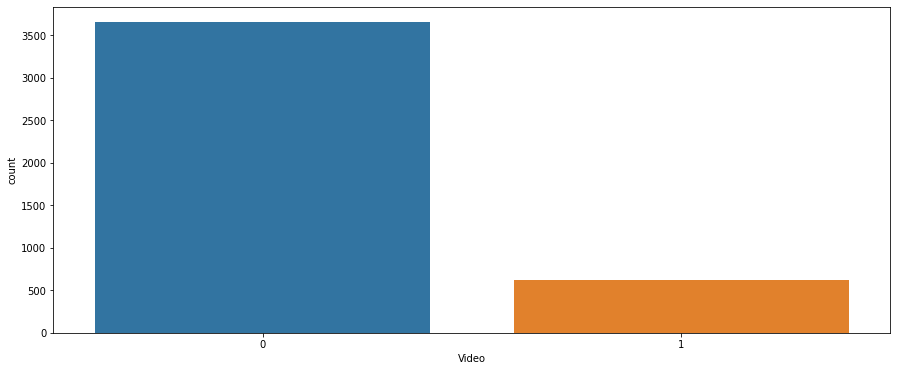

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data = dfcopy , x = 'Video')

In [ ]:
dff = dfcopy.copy()

The 'language' column is categorical and have 55 values, so we will transform it using the Ordinal Encoder

In [ ]:

#Encoder = OrdinalEncoder(dtype=int)
#Encoder.fit(dff[['language']])
with open('/content/drive/MyDrive/colab_datasets/twitterscraping/Encoder.pkl', 'rb') as pkl:
  Encoder = pickle.load(pkl)
dff[['language']] = Encoder.transform(dff[['language']])

In [ ]:
dff.head()

,NumberofTweets,NumberofFollowing,NumberofFollowers,Picture,Video,NumberOfComments,NumberOfRetweets,NumberOfLikes,tweetage,numberOfHashtags,numberOfTags,numberOfURLs,language
0,2610,51,35700,1,0,14,25,186,4,0,1,0,10
1,1390,277,159100,1,0,68,186,3700,4,0,1,0,9
2,6088,431,45600,1,0,0,19,255,4,1,0,0,49
3,408,71,49800,0,0,64,91,2200,4,0,0,0,9
4,2126,143,13200,0,0,68,183,1700,4,0,0,0,9


In [ ]:
dff.head()

,NumberofTweets,NumberofFollowing,NumberofFollowers,Picture,Video,NumberOfComments,NumberOfRetweets,NumberOfLikes,tweetage,numberOfHashtags,numberOfTags,numberOfURLs,language
0,2610,51,35700,1,0,14,25,186,4,0,1,0,10
1,1390,277,159100,1,0,68,186,3700,4,0,1,0,9
2,6088,431,45600,1,0,0,19,255,4,1,0,0,49
3,408,71,49800,0,0,64,91,2200,4,0,0,0,9
4,2126,143,13200,0,0,68,183,1700,4,0,0,0,9


The boxplot shows significant imbalance in the y axis

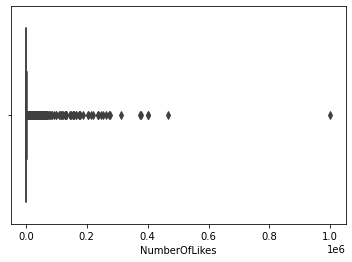

In [ ]:
sns.boxplot(x=dff['NumberOfLikes'])

The following histogram shows the distribution of the number of retweets and it shows that a large number of the data points are under the value of 2000, on the other hand, there are values that extend to more than 20 tousands which is surely indicates the existence of outliers.

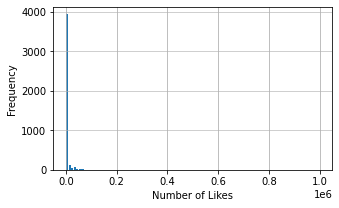

In [ ]:
plt.figure(figsize=(5, 3))
dff.NumberOfLikes.plot.hist(grid=True,range=[0,dff.NumberOfLikes.max()], bins=100, rwidth=0.9)
plt.xlabel('Number of Likes')
plt.grid(axis='y', alpha=0.75)
#dff = dff[dff.NumberOfLikes < 1001]

There are also outliers that does not appear in the y columns (the 'NumberOfLikes' column) but can rather be observed in the proportion between the number of retweets with the number of followers, followinf, and tweets, which indicates the existance of outliers. So there should be an outlier deletion technique that takes into account all the columns, not just the y column

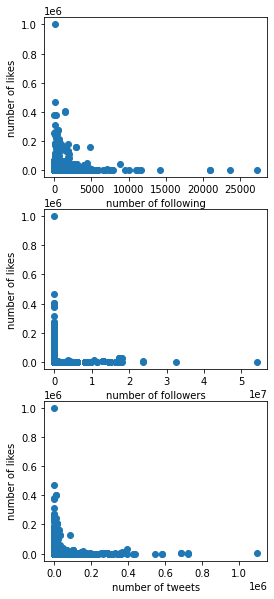

In [ ]:
fig, ax = plt.subplots(3,figsize=(4,10))
ax[0].scatter(dff['NumberofFollowing'],dff['NumberOfLikes'])
ax[0].set_xlabel('number of following')
ax[0].set_ylabel('number of likes')
ax[1].scatter(dff['NumberofFollowers'],dff['NumberOfLikes'])
ax[1].set_xlabel('number of followers')
ax[1].set_ylabel('number of likes')
ax[2].scatter(dff['NumberofTweets'],dff['NumberOfLikes'])
ax[2].set_xlabel('number of tweets')
ax[2].set_ylabel('number of likes')
plt.show()

"**the Z-score : The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.**"

To take into account all the columns upon performing the outlier rows selection, we use the z score which will give a good set of rows that are cadidated to be deleted

In [ ]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(dff))

"**You must be wondering that, how does this help in identifying the outliers? Well, while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.**"

This is a sorted list with all the rows that were considered as outliers by the z-score criterion (if abs of z score is above 3, than it is to be considered as an outlier), we will use it to delete them fro mthe dataset

In [ ]:
l = sorted(list(set.union(set(np.where(z > 3)[0]),set(np.where(z < -3)[0]))))
dff.drop(dff.index[l], inplace=True,axis=0)

Now, even the outliers related to the propotion between the number of retweets and the number of floowers, following, and number of tweets, are gone

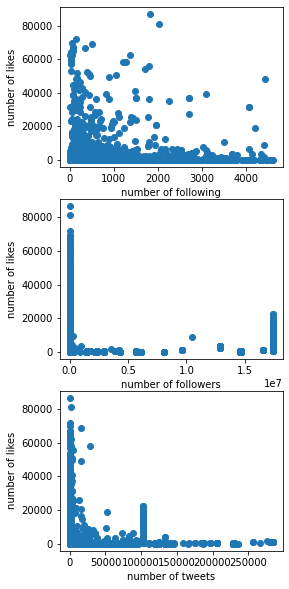

In [ ]:
fig, ax = plt.subplots(3,figsize=(4,10))
ax[0].scatter(dff['NumberofFollowing'],dff['NumberOfLikes'])
ax[0].set_xlabel('number of following')
ax[0].set_ylabel('number of likes')
ax[1].scatter(dff['NumberofFollowers'],dff['NumberOfLikes'])
ax[1].set_xlabel('number of followers')
ax[1].set_ylabel('number of likes')
ax[2].scatter(dff['NumberofTweets'],dff['NumberOfLikes'])
ax[2].set_xlabel('number of tweets')
ax[2].set_ylabel('number of likes')
plt.show()

The dataset is being split into x and y, with the 'NumberOfLikes' column is the the y

In [ ]:
dff = dff[dff.NumberOfLikes < 100]

In [ ]:
x = dff[['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers', 'Picture',
       'Video', 'tweetage', 'numberOfHashtags', 'numberOfTags', 'numberOfURLs','language']]
y = np.log10(dff['NumberOfLikes'] + 1)

The dataset is bring split into train and test datasets, with the test dataset being 12% of the original dataset

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.12,random_state=25)

In [ ]:
df = pd

In [ ]:
#Scaler = StandardScaler()
#Scaler.fit(x_train[['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers', 'numberOfHashtags', 'numberOfTags', 'numberOfURLs','tweetage','language']])
with open('/content/drive/MyDrive/colab_datasets/twitterscraping/Scaler.pkl', 'rb') as pkl:
  Scaler = pickle.load(pkl)
x_train[['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers', 'numberOfHashtags', 'numberOfTags', 'numberOfURLs','tweetage','language']] = Scaler.transform(x_train[['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers', 'numberOfHashtags', 'numberOfTags', 'numberOfURLs','tweetage','language']])
x_test[['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers', 'numberOfHashtags', 'numberOfTags', 'numberOfURLs','tweetage','language']] = Scaler.transform(x_test[['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers', 'numberOfHashtags', 'numberOfTags', 'numberOfURLs','tweetage','language']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

**"The Mutual Information is a measure of the similarity between two labels of the same data"**

"**We will use mutual information regression for feature ranking and selection. This metric measures the dependence between two random variables, in this case each feature in the data set and the number of retweets. Note that this doesn't consider combinations of feature values (for example, the dependence between number of followers and the y combined with number of tweets), which may also be useful**"

the mutual information score gives an idea on the important features in the x compared to the y

In [ ]:
import sklearn.feature_selection as fs
yt = [i for i in y_train]
featurerank = fs.mutual_info_regression(x_train,yt)
feature_scores = []
included_features = x_train.columns
for i in np.arange(len(included_features)):
  feature_scores.append([included_features[i],featurerank[i]])
sorted_scores = sorted(np.array(feature_scores),key=lambda s: float(s[1]), reverse=True)
print(np.array(sorted_scores))

[['NumberofFollowers' '0.30175954785227965']
 ['NumberofTweets' '0.30041461021555893']
 ['NumberofFollowing' '0.2122558822706102']
 ['tweetage' '0.10879395891857957']
 ['language' '0.0683362025943266']
 ['numberOfHashtags' '0.03167785297308434']
 ['Video' '0.016575852858908835']
 ['Picture' '0.0']
 ['numberOfTags' '0.0']
 ['numberOfURLs' '0.0']]


**"Linear model for testing the individual effect of each of many regressors. This is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure"**

f_regression is just another metric to help us in feature selection

In [ ]:
featureranking = fs.f_regression(x_train,yt)
feature_scoring = []
for i in np.arange(len(included_features)):
  feature_scoring.append([included_features[i],featureranking[0][i]])
sorted_sc = sorted(np.array(feature_scoring),key=lambda s: float(s[1]), reverse=True)
print(np.array(sorted_sc))

[['NumberofFollowers' '281.38812422706127']
 ['NumberofTweets' '267.46287535824683']
 ['tweetage' '117.84491768783876']
 ['numberOfURLs' '34.28610850105772']
 ['Video' '13.817530948342519']
 ['language' '3.95396930017046']
 ['numberOfHashtags' '3.4729396098076775']
 ['Picture' '1.6363211996430964']
 ['numberOfTags' '0.1608466111975235']
 ['NumberofFollowing' '0.0035151731695796896']]


**Selecting the most relevant columns :**

some columns are very very relevant to the y, and some others aren't that relevant. So, the irrelevant columns should be known to try to find a solution for them

In [ ]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(rfr(n_estimators = 100))
sel.fit(x_train, y_train)
sel.get_support()
x_train.columns[(sel.get_support())]

Index(['NumberofTweets', 'NumberofFollowing', 'NumberofFollowers'], dtype='object')

So it turned out, only the 'NumberofTweets', 'NumberofFollowing', 'NumberofFollowers' columns are the most relevant and informative to the model concerning the y column.
Now, let's try to reduce the number of columns by using PCA on the least relevant columns to the y column

In [ ]:
d = {}
for i in range(len(x_train.columns)-1):
  for j in range(i+1,len(x_train.columns)):
    aa = x_train[[x_train.columns[i],x_train.columns[j]]]
    pca = PCA(n_components=1)
    aa = pca.fit_transform(aa)
    d[x_train.columns[i] + ' ' + x_train.columns[j]] = pca.explained_variance_ratio_
d

{'NumberofFollowers Picture': array([0.83491208]),
 'NumberofFollowers Video': array([0.89943578]),
 'NumberofFollowers language': array([0.56701835]),
 'NumberofFollowers numberOfHashtags': array([0.58196555]),
 'NumberofFollowers numberOfTags': array([0.56531082]),
 'NumberofFollowers numberOfURLs': array([0.66005943]),
 'NumberofFollowers tweetage': array([0.7946824]),
 'NumberofFollowing NumberofFollowers': array([0.61061803]),
 'NumberofFollowing Picture': array([0.8197516]),
 'NumberofFollowing Video': array([0.8894195]),
 'NumberofFollowing language': array([0.57139652]),
 'NumberofFollowing numberOfHashtags': array([0.59200727]),
 'NumberofFollowing numberOfTags': array([0.58392011]),
 'NumberofFollowing numberOfURLs': array([0.59298096]),
 'NumberofFollowing tweetage': array([0.62670589]),
 'NumberofTweets NumberofFollowers': array([0.92421677]),
 'NumberofTweets NumberofFollowing': array([0.60489722]),
 'NumberofTweets Picture': array([0.86716647]),
 'NumberofTweets Video': a

So basically, the Video and Picture columns are very good for preserving the information along with any other column that is not very relevant to the model, especially NumberOfTags, NumberOfHashtags, and NumberOfLinks. It is observable that the results between these three and column Video or column Picture is very close so the selection will not be on the basis of the highest explained_variance_ratio_ value, but rather will be on the basis of how closely relevant the column is to the y column where the most relevant among the will stay 'unmerged' with another column.
Looking back to the result that we get from the mutual information score which measures the dependance between the x columns and the y column. We got this previously :
 
                 ['numberOfHashtags' '0.08560174137269616']

                 ['numberOfTags' '0.0500935962796909']

                 ['numberOfURLs' '0.04733436430045623']

 which indicates that we will merge the NumberOfTags and NumberOfURLs columns together with the Video and Picture columns.

 Choosing the correspondance of the pairs is done on the basis of the explained_variance_ratio_ value; the pairs to be putten through the PCA process are :

                ['Video' , 'numberOfTags']
                
                ['Picture' , 'numberOfURLs']


In [ ]:
videotagstrain = x_train[['Video' , 'numberOfTags']]
picurlstrain = x_train[['Picture' , 'numberOfURLs']]
videotagstest = x_test[['Video' , 'numberOfTags']]
picurlstest = x_test[['Picture' , 'numberOfURLs']]
#pcavtag = PCA(n_components=1)
#pcapurl = PCA(n_components=1)
#pcavtag.fit(videotagstrain)
#pcapurl.fit(picurlstrain)
with open('/content/drive/MyDrive/colab_datasets/twitterscraping/pcavtag.pkl', 'rb') as pkl:
  pcavtag = pickle.load(pkl)
with open('/content/drive/MyDrive/colab_datasets/twitterscraping/pcapurl.pkl', 'rb') as pkl:
  pcapurl = pickle.load(pkl)
videotagstrain = pcavtag.transform(videotagstrain)
picurlstrain = pcapurl.transform(picurlstrain)
x_train['VideoNTags'] = 0
x_train['PictureNURL'] = 0
x_train['VideoNTags'] = videotagstrain.reshape(1,-1)[0]
x_train['PictureNURL'] = picurlstrain.reshape(1,-1)[0]
videotagstest = pcavtag.transform(videotagstest)
picurlstest = pcapurl.transform(picurlstest)
x_test['VideoNTags'] = 0
x_test['PictureNURL'] = 0
x_test['VideoNTags'] = videotagstest.reshape(1,-1)[0]
x_test['PictureNURL'] = picurlstest.reshape(1,-1)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
x_train = x_train.drop(columns=['Video' , 'numberOfTags' , 'Picture' , 'numberOfURLs'])
x_test = x_test.drop(columns=['Video' , 'numberOfTags' , 'Picture' , 'numberOfURLs'])

**HyperParameter tuning :**

The RandomForestRegressor model will be used due to its good reoutation in finding a good estimator and the fact that it doesn't overfit easily. So a hyperparameter tuning procedure is necessary to get a good estimator

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 12],
    'n_estimators': [10, 50, 70, 100]
}
rrf = rfr()
grids_search = GridSearchCV(estimator = rrf, param_grid = param_grid,
                          cv = 10, n_jobs = -1, verbose = 2)
grids_search.fit(x_train,y_train)
classfff = grids_search.best_estimator_
y_preds = classfff.predict(x_test)
y_t = y_test.apply(lambda x: 10**x)- 1
y_preds = pd.Series(y_preds).apply(lambda x: 10**x) - 1
vals_error = mean_absolute_error(y_t, y_preds)
vals_error

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.6s finished


12.241786174161582

In [ ]:
(1/y_test.shape[0])*(y_test - y_preds).abs().divide(y_test + 1,fill_value=0).sum()

0.20855387244792295

In [ ]:
(y_train.apply(lambda x: 10**x) - 1).mean()

19.25359911406423

In [ ]:
y_test.median()

1.0

In [ ]:
param_grid = {'bootstrap': [True],
 'criterion': ['mse'],
 'max_depth': [2, 12],
 'n_estimators': [100, 200, 300, 1000],
 'max_features': [3 , 5 , 10],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [8, 10, 12],
 'max_leaf_nodes': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_weight_fraction_leaf': [0.0],
 'oob_score': [False],
 'random_state': [42],
 'warm_start': [True,False],
 }
rrf = rfr()
grids_search = GridSearchCV(estimator = rrf, param_grid = param_grid,
                          cv = 10, n_jobs = -1, verbose = 2)
grids_search.fit(x_train,y_train)
classfff = grids_search.best_estimator_
y_t = y_test.apply(lambda x: 10**x)- 1
y_preds = classfff.predict(x_test)
vals_error = mean_absolute_error(y_t, y_preds)
vals_error

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2291 tasks      | elapsed: 11.9min


KeyboardInterrupt: ignored

In [ ]:
best = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=True)
best.fit(x_train,y_train)
y_t = y_test.apply(lambda x: 10**x)- 1
y_preds = pd.Series(best.predict(x_test)).apply(lambda x: 10**x)- 1
vals_error = mean_absolute_error(y_t, y_preds)
vals_error

12.588010001158043

In [ ]:
p = [y_t.reset_index().drop(columns=['index']),y_preds.astype('int64')]
pd.concat(p,axis=1).head(60)

,NumberOfLikes,0
0,18.0,10
1,8.0,7
2,71.0,3
3,0.0,5
4,1.0,3
5,1.0,5
6,81.0,75
7,17.0,15
8,2.0,5
9,28.0,10


In [ ]:
xtrain = x_train.drop(columns=['language'])
xtest = x_test.drop(columns=['language'])

In [ ]:
param_tuning = {
        'max_depth': [12],
        'min_child_weight': [1],
        'subsample': [0.7],
        'colsample_bytree': [0.7],
        'n_estimators' : [2000],
        'objective': ['reg:squarederror']
}

xgb_model = XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_median_absolute_error',
                           cv = 20,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(x_train,y_train)
bst = gsearch.best_estimator_
bst.fit(x_train,y_train)

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [ ]:
bst = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)
bst.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [ ]:
y_pr = pd.Series(bst.predict(x_test))

In [ ]:
y_pr = pd.Series(bst.predict(x_test)).apply(lambda x : 10**x) - 1

In [ ]:
y_t = y_test.apply(lambda x : 10**x) - 1

In [ ]:
mean_absolute_error(y_t, y_pr)

11.602775624637873

In [ ]:
(1/y_t.shape[0])*(y_t - y_pr).abs().divide(y_t + 1,fill_value=0).sum()

0.0845460368027909

In [ ]:
bst.save_model("likemodel.bin")
model_xgb_2 = xgb.Booster()
model_xgb_2.load_model("likemodel.bin")

Saving the model :

So for saving the model, it should be done

In [ ]:
import joblib
filename = 'examplemodel.sav'
joblib.dump(best, filename)
loaded_model = joblib.load(filename)

In [ ]:
import pickle
with open('/content/drive/MyDrive/colab_datasets/twitterscraping/likesexemplemodel.pkl', 'wb') as pkl:
    pickle.dump(best, pkl)
with open('/content/drive/MyDrive/colab_datasets/twitterscraping/likesexemplemodel.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl)

In [ ]:
import joblib
filename = 'Scaler.sav'
joblib.dump(Scaler, filename)
loaded_model = joblib.load(filename)

In [ ]:
import pickle
with open('Scaler.pkl', 'wb') as pkl:
    pickle.dump(Scaler, pkl)
with open('Scaler.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl)

In [ ]:
import joblib
filename = 'Encoder.sav'
joblib.dump(bst, filename)
loaded_model = joblib.load(filename)

In [ ]:
import pickle
with open('Encoder.pkl', 'wb') as pkl:
    pickle.dump(Encoder, pkl)
with open('Encoder.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl)

In [ ]:
import joblib
filename = 'pcavtag.sav'
joblib.dump(bst, filename)
loaded_model = joblib.load(filename)

In [ ]:
import pickle
with open('pcavtag.pkl', 'wb') as pkl:
    pickle.dump(pcavtag, pkl)
with open('pcavtag.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl)

In [ ]:
import joblib
filename = 'pcapurl.sav'
joblib.dump(bst, filename)
loaded_model = joblib.load(filename)

In [ ]:
import pickle
with open('pcapurl.pkl', 'wb') as pkl:
    pickle.dump(pcapurl, pkl)
with open('pcapurl.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl)